In [1]:
import os
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch 

import sys

sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation')
sys.path.append('/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

sys.path

['/home/calessi-iit.local/Projects/hannes-imitation/tests',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python39.zip',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/lib-dynload',
 '',
 '/home/calessi-iit.local/miniforge3/envs/robodiff/lib/python3.9/site-packages',
 '/home/calessi-iit.local/Projects/hannes-imitation',
 '/home/calessi-iit.local/Projects/hannes-imitation/hannes_imitation/external/diffusion_policy']

### Get dataset

In [2]:
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset

merged_dir = '/home/calessi-iit.local/Projects/hannes-imitation/data/preliminary/'
merged_name = 'merged.zarr'
zarr_path = os.path.join(merged_dir, merged_name)
keys = ['image_in_hand', 'ref_move_hand']
val_ratio = 0.1
seed = 72
max_train_episodes = None
horizon = 16 # prediction horizon
observation_horizon = 2
action_horizon = 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
train_dataset = HannesImageDataset(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)
validation_dataset = train_dataset.get_validation_dataset()

# get normalizer
normalizer = train_dataset.get_normalizer()


# create dataloaders for training and validation
batch_size = 64
num_workers = 4
shuffle = True

# pin_memory = True accelerates cpu-gpu transfer
# persistent_workers = True does not kill worker process after each epoch
tr_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True, persistent_workers=True)
vl_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# visualize data in batch
# TODO discard unused observations earlier
batch = next(iter(tr_dataloader))
print("batch['obs']['image_hand']", batch['obs']['image_in_hand'].shape, batch['obs']['image_in_hand'].dtype)
print("batch['action']", batch['action'].shape, batch['action'].dtype)

### Get image observation encoder

  obs_encoder:
    _target_: diffusion_policy.model.vision.multi_image_obs_encoder.MultiImageObsEncoder
    shape_meta: ${shape_meta}
    rgb_model:
      _target_: diffusion_policy.model.vision.model_getter.get_resnet
      name: resnet18
      weights: null
    resize_shape: null
    crop_shape: [76, 76]
    # constant center crop
    random_crop: True
    use_group_norm: True
    share_rgb_model: False
    imagenet_norm: True

image_shape: &image_shape [3, 96, 96]
shape_meta: &shape_meta
  # acceptable types: rgb, low_dim
  obs:
    image:
      shape: *image_shape
      type: rgb
    agent_pos:
      shape: [2]
      type: low_dim
  action:
    shape: [2]

In [3]:
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.multi_image_obs_encoder import MultiImageObsEncoder
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.model_getter import get_resnet

In [4]:
# Create shape_meta
item = train_dataset.__getitem__(0)
_, C, H, W = item['obs']['image_in_hand'].shape
_, action_dim = item['action'].shape

# Make sure that `shape_meta` correspond to input and output shapes for your task.
shape_meta = dict(obs=dict(), action=dict())
shape_meta['obs']['image_in_hand'] = dict(shape=(C, H, W), type='rgb')
shape_meta['action'] = dict(shape=[action_dim])

# NOTE if you want to include more observations
#shape_meta['obs']['image_in_head'] = dict(shape=(C, H, W), type='rgb')
#shape_meta['obs']['hand_info'] = dict(shape=[6], type='low_dim')

In [5]:
# Create observation encoder
rgb_model = get_resnet('resnet18') # dict()

# The MultiImageObsEncoder encodes image and low dimensional observations into a single observation.
# The constructor requires 2 positional arguments (shape_meta, rgb_model).
# rgb_model can be directly an nn.Module or a Dict[str,nn.Module]

# Optionally, you can specify if the image is resized (`resize_shape`) and/or cropped (`crop_shape`, `random_crop`) and/or
# normalized according to imagenet values (`imagenet_norm`)
# These transformations are performed in the forward() method.
# We only use imagenet_norm.
observation_encoder = MultiImageObsEncoder(shape_meta=shape_meta, rgb_model=rgb_model,
                                       resize_shape=None,
                                       crop_shape=None,
                                       random_crop=False,
                                       use_group_norm=True,
                                       share_rgb_model=True,
                                       imagenet_norm=True)

# freeze observation_encoder
_ = observation_encoder.eval()

In [6]:
#item['obs']['image_in_head'] = torch.zeros_like(item['obs']['image_in_hand'])
#item['obs']['hand_info'] = torch.ones((16,6))

# The forward model takes as input the dictinonary of observation `obs_dict`
# if obs_dict contains more observations of type `rgb`, their features are concatenated
# if obs_dict contains observations with low dimensions (of type `low_dim`), they are directly concatenated after the images' features
observation_encoder(item['obs']).shape

torch.Size([16, 512])

### Get models

In [7]:
#from hannes_imitation.model.diffusion.conditional_unet1d import ConditionalUnet1D
#from hannes_imitation.model.vision.model_getter import get_resnet


#from hannes_imitation.common.pytorch_util import replace_bn_with_gn

# diffusion policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
#from hannes_imitation.external.diffusion_policy.diffusion_policy.model.vision.model_getter import get_resnet
#from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import replace_submodules

import torch.nn as nn

In [ ]:
# construct ResNet18 encoder
# if you have multiple camera views, use seperate encoder weights for each view.
#vision_encoder = get_resnet('resnet18')

# IMPORTANT!
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
#vision_encoder = replace_bn_with_gn(vision_encoder)

#_ = vision_encoder.eval()

In [ ]:
#vision_feature_dim = observation_encoder.output_shape()[0] #512 #  ResNet18 output dimensionality
#lowdim_obs_dim = 2 # # agent_pos is 2 dimensional

#action_dim = batch['action'].shape[-1]
#observation_dim = vision_feature_dim# + lowdim_obs_dim
#conditioning_dim = observation_dim * observation_horizon

# create network object
# input_dim, local_cond_dim=None, global_cond_dim=None, diffusion_step_embed_dim=256, down_dims=[256,512,1024], kernel_size=3, n_groups=8, cond_predict_scale=False)
#noise_predictor = ConditionalUnet1D(input_dim=action_dim, global_cond_dim=conditioning_dim, 
#                                   diffusion_step_embed_dim=256,
#                                   down_dims=[32, 64, 128])#[256,512,1024])

In [ ]:
# the final arch has 2 parts
#nets = nn.ModuleDict({'observation_encoder': observation_encoder, 
#                      'noise_predictor': noise_predictor})

In [ ]:
# device transfer
#device = torch.device('cpu')
#device = torch.device('cuda')
#_ = nets.to(device)

In [ ]:
#nets['observation_encoder'].training, nets['noise_predictor'].training

In [ ]:
# demo 1
#with torch.no_grad():
#    # example inputs
#    image = torch.zeros((1, observation_horizon, 3, 96, 96))
#    #agent_pos = torch.zeros((1, obs_horizon, 2))
#    
#    # vision encoder
#    image = image.flatten(end_dim=1) # squeeze, (obs_horizon=2, 3, 96, 96)
#    image_features = nets['vision_encoder'](image) # (obs_horizon=2, 512)
#    image_features = torch.unsqueeze(image_features, dim=0) # unsqueeze, (1,2,512)
#    
#    #obs = torch.cat([image_features, agent_pos], dim=-1) # (1,2,514)
#    obs = image_features#
#
#    # action diffusion
#    noised_action = torch.randn((1, prediction_horizon, action_dim))
#    diffusion_iter = torch.zeros((1,))
#
#    # the noise prediction network
#    # takes noisy action, diffusion iteration and observation as input
#    # predicts the noise added to action (1, pred_horizon=16, action_dim=2)
#    # the conditional observation gets flattened into (1, 1028)
#    noise = nets['noise_predictor'](
#        sample=noised_action,
#        timestep=diffusion_iter,
#        global_cond=obs.flatten(start_dim=1)) #
#
#    # illustration of removing noise
#    # the actual noise removal is performed by NoiseScheduler
#    # and is dependent on the diffusion noise schedule
#    denoised_action = noised_action - noise

In [8]:
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

# demo 2
# for this demo, we use DDPMScheduler with 100 diffusion iterations
# NOTE: the choice of beta schedule has big impact on performance. We found squared cosine works the best
num_diffusion_iters = 100

noise_scheduler = DDPMScheduler(num_train_timesteps=num_diffusion_iters,
                                beta_schedule='squaredcos_cap_v2',
                                clip_sample=True, # clip output to [-1,1] to improve stability
                                prediction_type='epsilon') # the network predicts noise (instead of denoised action)

In [ ]:
#from hannes_imitation.model.diffusion.ema_model import EMAModel

# Exponential Moving Average accelerates training and improves stability
# holds a copy of the model weights
#ema = EMAModel(parameters=nets.parameters(), power=0.75)
#ema = EMAModel(model=nets, power=0.75)

In [ ]:
#resnet_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#_ = normalizer.to(device)

## Policy

In [9]:
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy

In [10]:
device = torch.device('cuda')

In [11]:
# DiffusionUnetImagePolicy requires 6 positional arguments
# shape_meta is a dictionary that contains the shapes of observations and actions for the task
# noise_scheduler is an instance of DDPMScheduler noise scheduler
# obs_encoder is an instance of MultiImageObsEncoder which encodes images and low dimensional observations as conditioning
# horizon is the prediction horizon (action prediction horizon)
# n_action_steps is the action execution horizon (how many actions are actually executed from the prediction)
# n_obs_steps is the observation horizon (how many recent observations to include as condition)

# NOTE: there are other parameters that we do not change, except for the UNet model size


policy = DiffusionUnetImagePolicy(shape_meta=shape_meta, 
                                  noise_scheduler=noise_scheduler, 
                                  obs_encoder=observation_encoder,
                                  horizon=horizon,
                                  n_action_steps=action_horizon,
                                  n_obs_steps=observation_horizon,
                                  diffusion_step_embed_dim=128,#256,
                                  down_dims=[32, 64, 128])#(256,512,1024))

#_ = policy.to(device)

In [ ]:
#normalizer = normalizer.to(device)
#policy.set_normalizer(normalizer=normalizer)

In [12]:
# Create optimizer and learning rate scheduler
# Standard ADAM optimizer (NOTE that EMA parametesr are not optimized)
optimizer = torch.optim.AdamW(params=policy.parameters(), lr=1e-4, weight_decay=1e-6)

from hannes_imitation.model.common.lr_scheduler import get_scheduler
from tqdm import tqdm
from torchvision import transforms
from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import dict_apply

num_epochs = 100 #100 # 100

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(tr_dataloader) * num_epochs)

In [ ]:
from hannes_imitation.trainer.trainer_diffusion_policy import TrainerDiffusionPolicy


policy_trainer = TrainerDiffusionPolicy(policy=policy, 
                                        optimizer=optimizer, 
                                        normalizer=normalizer, 
                                        tr_dataloader=tr_dataloader, 
                                        vl_dataloader=vl_dataloader, 
                                        learning_rate_scheduler=lr_scheduler)

In [14]:
history = policy_trainer.run(num_epochs=num_epochs, device=device)

Epoch: 100%|██████████| 100/100 [38:57<00:00, 23.38s/it, tr_loss=0.0043, vl_loss=0.0666, vl_action_error=3.94]


In [15]:
# save model
policy_dir = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/'
policy_name = 'preliminary_policy.pth'
policy_path = os.path.join(policy_dir, policy_name)

training_dict = {'policy': policy.to('cpu'),
                 'policy_state_dict': policy.state_dict(),
                 'optimizer': optimizer,
                 'noise_scheduler': noise_scheduler,
                 'history': history
                }

torch.save(training_dict, policy_path)

print("Training saved in %s" % str(policy_path))

Training saved in /home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy.pth


### Check training

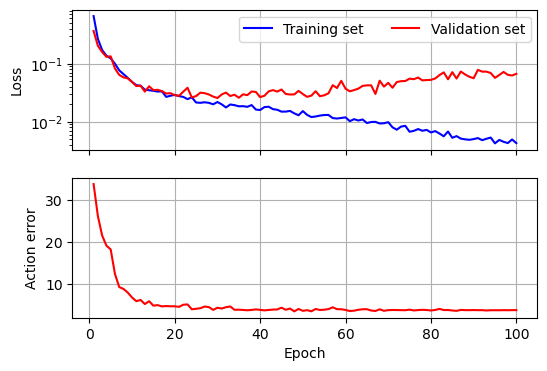

In [16]:
# load model
checkpoint = torch.load('/home/calessi-iit.local/Projects/hannes-imitation/trainings/preliminary_policy.pth')

policy = checkpoint['policy']
history = checkpoint['history']

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,4), sharex=True)
ax1.plot(history['epoch'], history['tr_loss'], label='Training set', color='blue')
ax1.plot(history['epoch'], history['vl_loss'], label='Validation set', color='red')
ax1.set_yscale('log')
#ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend(ncols=2)

ax2.plot(history['epoch'], history['vl_action_error'], color='red')
ax2.set_xlabel("Epoch")
ax2.set_ylabel('Action error')
ax2.grid()
plt.show()

- allineamento temporale con frame passato
- grafico errore predizione azione durante la demo sulla validazione.
- usa min e max (0,100), non i min e max del training set.
- fai video con su scritto azione predetta e azione vera
- 

### old

In [ ]:
def validate(nets, vl_dataloader):
    vl_batch_losses = []

    with torch.no_grad():
        for nbatch in vl_dataloader:
            obs_dict = nbatch['obs']
            
            # discard unused observation
            # flatten observation horizon and batch size into a single dimension (B*observation_horizon), keeping other dimensions
            # send to device
            obs_dict = dict_apply(obs_dict, lambda x: x[:,:observation_horizon,...])
            obs_dict = dict_apply(obs_dict, lambda x: x.reshape(-1,*x.shape[2:])) # (B*observation_horizon, n_channels, H, W)
            obs_dict = dict_apply(obs_dict, lambda x: x.to(device))

            # normalize batch (discard unused observation)
            #nimage = nbatch['obs']['image_in_hand'][:, :observation_horizon] # (B, observation_horizon, n_channels, H, W)
            #nimage = nimage.to(device)
            #nimage = resnet_normalizer(nimage)

            naction = nbatch['action'].to(device)
            naction = normalizer['action'].normalize(naction)
            #B, _, n_channels, H, W = nimage.shape

            B, _, _ = nbatch['action'].shape

            # encoder vision features
            #images = nimage.reshape(-1, n_channels, H, W) # (B*observation_horizon, n_channels, H, W)
            #image_features = nets['vision_encoder'](images) # (B*observation_horizon, features_dim)
            #image_features = image_features.reshape(B, observation_horizon, -1) # (B, observation_horizon, features_dim)

            # conditional observation flattened. Concatenate vision feature and, if any, other low-dim obs
            #obs_features = torch.cat([image_features, nagent_pos], dim=-1)
            #obs_features = image_features
            #obs_cond = obs_features.reshape(B, -1) # (B, obs_horizon * obs_dim)
            obs_cond = observation_encoder(obs_dict).reshape(B, -1)

            # sample noise to add to actions
            noise = torch.randn(naction.shape, device=device)

            # sample a diffusion iteration for each data point
            timesteps = torch.randint(low=0, high=noise_scheduler.config.num_train_timesteps, size=(B,), device=device).long()

            # Forward diffusion process. Add noise to the clean images according to the noise magnitude at each diffusion iteration
            noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

            # predict the noise residual
            # the noise prediction network takes noisy action, diffusion iteration and observation as input and predicts the noise added to naction (1, pred_horizon=16, action_dim=2)
            noise_pred = nets['noise_predictor'](noisy_actions, timesteps, global_cond=obs_cond)

            # L2 loss
            loss = nn.functional.mse_loss(noise_pred, noise)

            vl_batch_losses.append(loss.item())
    
    vl_loss = np.mean(vl_batch_losses)

    return vl_loss

In [ ]:
history = {'epoch': list(), 
           'tr_loss': list(), 
           'vl_loss': list()}

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(tr_dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # normalize batch (discard unused observation)
                #nimage = nbatch['obs']['image_in_hand'][:, :observation_horizon] # (B, observation_horizon, n_channels, H, W)
                #nimage = nimage.to(device)
                #nimage = resnet_normalizer(nimage)
                
                obs_dict = nbatch['obs']
                
                # discard unused observation
                #for key in obs_dict.keys():
                #    obs_dict[key] = obs_dict[key][:, :observation_horizon]
                # discard unused observation
                obs_dict = dict_apply(obs_dict, lambda x: x[:,:observation_horizon,...])
                # flatten observation horizon and batch size into a single dimension (B*observation_horizon), keeping other dimensions
                obs_dict = dict_apply(obs_dict, lambda x: x.reshape(-1,*x.shape[2:])) # (B*observation_horizon, n_channels, H, W)
                # send to device
                obs_dict = dict_apply(obs_dict, lambda x: x.to(device))

                naction = nbatch['action'].to(device)
                naction = normalizer['action'].normalize(naction)
                #B, _, n_channels, H, W = nimage.shape
                B, _, _ = nbatch['action'].shape

                # encoder vision features
                #images = nimage.reshape(-1, n_channels, H, W) # (B*observation_horizon, n_channels, H, W)
                #image_features = nets['vision_encoder'](images) # (B*observation_horizon, features_dim)
                #image_features = image_features.reshape(B, observation_horizon, -1) # (B, observation_horizon, features_dim)

                # conditional observation flattened. Concatenate vision feature and, if any, other low-dim obs
                #obs_features = torch.cat([image_features, nagent_pos], dim=-1)
                #obs_features = image_features
                #obs_cond = obs_features.reshape(B, -1) # (B, obs_horizon * obs_dim)

                obs_cond = observation_encoder(obs_dict).reshape(B, -1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(low=0, high=noise_scheduler.config.num_train_timesteps, size=(B,), device=device).long()

                # Forward diffusion process. Add noise to the clean images according to the noise magnitude at each diffusion iteration
                noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

                # predict the noise residual
                # the noise prediction network takes noisy action, diffusion iteration and observation as input and predicts the noise added to naction (1, pred_horizon=16, action_dim=2)
                noise_pred = nets['noise_predictor'](noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step() # step lr scheduler every batch. This is different from standard pytorch behavior

                # update Exponential Moving Average of the model weights
                #ema.step(nets.parameters())
                #ema.step(nets)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)

        # evaluate model on validation set after each epoch
        vl_loss = validate(nets=nets.to(device), vl_dataloader=vl_dataloader)

        tglobal.set_postfix(loss=np.mean(epoch_loss))

        history['epoch'].append(epoch_idx + 1)
        history['tr_loss'].append(np.mean(epoch_loss))
        history['vl_loss'].append(vl_loss)